## Imports

In [223]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



# Business Understanding
**Question 1: Which U.S. regions have experienced the fastest growth in new business applications over time?**

**Question 2: How do different regions compare in terms of business application volume in recent years?** 

**Question 3: How well can we predict future business formation activity based on historical data?**


## Load Data

In [224]:
#load DF
#https://www.census.gov/econ/bfs/data/county.html
df1 = pd.read_excel(r"bfs_county_apps_annual.xlsx")

## Examine Data/ Data Understanding 

In [225]:
#gather info of DF
print(df1.head())

  State          County  County Code  state_fips  county_fips BA2005 BA2006  \
0    AL  Autauga County         1001           1            1    335    348   
1    AL  Baldwin County         1003           1            3   1986   2101   
2    AL  Barbour County         1005           1            5    138    179   
3    AL     Bibb County         1007           1            7    118    145   
4    AL   Blount County         1009           1            9    315    323   

  BA2007 BA2008 BA2009  ... BA2015 BA2016 BA2017 BA2018 BA2019 BA2020 BA2021  \
0    348    367    288  ...    291    294    313    384    394    559    776   
1   1975   1721   1505  ...   1735   1858   2114   2104   2317   2697   3407   
2    156    139    133  ...    129    122    114    113    135    230    334   
3    117     98     98  ...     78     86     79    105     86    165    199   
4    297    306    247  ...    218    254    281    299    312    344    473   

  BA2022 BA2023 BA2024  
0    703    722    

In [226]:
#gather info for DF
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156 entries, 0 to 3155
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   State        3156 non-null   object
 1   County       3156 non-null   object
 2   County Code  3156 non-null   int64 
 3   state_fips   3156 non-null   int64 
 4   county_fips  3156 non-null   int64 
 5   BA2005       3156 non-null   object
 6   BA2006       3156 non-null   object
 7   BA2007       3156 non-null   object
 8   BA2008       3156 non-null   object
 9   BA2009       3156 non-null   object
 10  BA2010       3156 non-null   object
 11  BA2011       3156 non-null   object
 12  BA2012       3156 non-null   object
 13  BA2013       3156 non-null   object
 14  BA2014       3156 non-null   object
 15  BA2015       3156 non-null   object
 16  BA2016       3156 non-null   object
 17  BA2017       3156 non-null   object
 18  BA2018       3156 non-null   object
 19  BA2019       3156 non-null 

# Clean Data/ Data Preparation

Converting the State and County columns into a “category” data type. This tells Python that these columns contain repeating labels rather than just numbers this speeds up analysis. Then clean up the column names by removing the “BA” prefix from any column that starts with it. 

In [227]:
#convert categorical columns
df1['State'] = df1['State'].astype('category')
df1['County'] = df1['County'].astype('category')
df1.rename(columns=lambda x: x.replace('BA', '') if x.startswith('BA') else x, inplace=True)



Identify the columns that represent years by checking for column names made up of only digits. Then sort those year columns in numerical order to keep them in the correct timeline. Finally, you convert all values in the year columns into numbers.

In [228]:
#identify year columns (now just numbers)
year_cols = [c for c in df1.columns if isinstance(c, str) and c.isdigit()]
year_cols = sorted(year_cols, key=int)
for col in year_cols:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')

# Analyze

In [229]:
#group by State and calculate mean for numeric columns only
state_trends = df1.groupby('State')[year_cols].mean()
#Transpose for plotting
state_trends = state_trends.T
print (state_trends)


State          AK           AL          AR           AZ           CA  \
2005   163.103448   463.850746  255.106667  3769.800000  4683.379310   
2006   180.310345   506.238806  272.000000  4204.466667  4942.275862   
2007   177.172414   503.000000  261.733333  4311.533333  4943.741379   
2008   171.689655   480.925373  249.426667  4198.133333  4682.862069   
2009   151.586207   436.134328  239.026667  3885.266667  4297.344828   
2010   160.724138   446.507463  237.906667  3861.733333  4421.310345   
2011   175.275862   432.746269  239.186667  3855.800000  4656.155172   
2012   179.655172   443.194030  237.493333  3687.000000  4622.465517   
2013   185.620690   437.776119  234.013333  3701.066667  4793.344828   
2014   187.827586   441.402985  245.933333  3760.066667  5059.362069   
2015   203.482759   470.238806  253.773333  3811.733333  5235.465517   
2016   219.241379   511.731343  272.600000  4096.533333  5390.275862   
2017   250.448276   548.656716  308.466667  4522.200000  5630.89

C:\Users\carson.rodriguez\AppData\Local\Temp\ipykernel_21256\2946389368.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_trends = df1.groupby('State')[year_cols].mean()


The code groups everything by state, taking the average of all counties in that state for each year. Then it flips the table so each column is a state and each row is a year, and plots lines showing the average number of business applications per state over time. This gives a good visual sense of which states are trending up or down.

In [230]:
# Define the formatter
def thousands_formatter(x, pos):
    """
    Helps format some of the data by dividing it by 1000

    Args:
        x : The value to be formated 

    Returns:
       number with the k place
    """
    return f'{int(x/1000)}K'

Map the states into regions to then combine and gather the mean.

In [231]:
regions = {
    'Northeast': [
        #New England 
        'CT', 'ME', 'MA', 'NH', 'RI', 'VT',
        #Middle Atlantic 
        'NJ', 'NY', 'PA'
    ],

    'Midwest': [
        #East North Central 
        'IL', 'IN', 'MI', 'OH', 'WI',
        #West North Central 
        'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'
    ],

    'South': [
        #South Atlantic 
        'DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV',
        #East South Central 
        'AL', 'KY', 'MS', 'TN',
        #West South Central 
        'AR', 'LA', 'OK', 'TX'
    ],

    'West': [
        #Mountain 
        'AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY',
        #Pacific 
        'AK', 'CA', 'HI', 'OR', 'WA'
    ]
}


In [232]:
def get_region_means(df, regions, year_cols):

    """
    Getting the mean across the different regions 
    Args:
        df : data frame of regions
        regions : the regions
        year_cols : the yeaes
        
    Returns:
        means by regions 
    """

    out = pd.DataFrame(index=year_cols)
    for r, states in regions.items():
        out[r] = df[df["State"].isin(states)][year_cols].mean()
    out.index = out.index.astype(int)
    return out.sort_index()

def get_region_totals(df, regions, year_cols):
    """
    Gets the total across regions 

    Args:
        df : data frame of regions
        regions : the regions
        year_cols : the yeaes

    Returns:
        totals by region
    """
    
    out = pd.DataFrame(index=year_cols)
    for r, states in regions.items():
        out[r] = df[df["State"].isin(states)][year_cols].sum()
    out.index = out.index.astype(int)
    return out.sort_index()

This function is used to show how confident the model’s predictions are by giving an upper and lower bound instead of just one number. It works by training the model many times on random samples of the original training data. Each time its making new predictions for future values. After repeating this process the function looks at all those predictions and finds the range where most of them fall. The lower and upper values of that range become the confidence interval meaning the true future value is likely to fall between those two numbers. This gives a more realistic picture of uncertainty in the forecast.

In [233]:
future_years = ['2025', '2026', '2027']
colors = {'Northeast': 'blue', 'Midwest': 'orange', 'South': 'green', 'West': 'purple'}

def prediction_interval(model, X_future, X_train, y_train, n_bootstrap=500, alpha=0.05):
    """
    Predicting a upper and lower bound (variance) for the data.

    Args:
        model (_type_): _description_
        X_future (_type_): _description_
        X_train (_type_): _description_
        y_train (_type_): _description_
        n_bootstrap (int, optional): _description_. Defaults to 500.
        alpha (float, optional): _description_. Defaults to 0.05.

    Returns:
        _type_: _description_
    """

    preds = []
    for _ in range(n_bootstrap):
        sample_idx = np.random.choice(len(X_train), len(X_train), replace=True)
        X_sample = X_train[sample_idx]
        y_sample = y_train[sample_idx]
        model.fit(X_sample, y_sample)
        preds.append(model.predict(X_future))
    preds = np.array(preds)
    lower = np.percentile(preds, 100 * alpha / 2, axis=0)
    upper = np.percentile(preds, 100 * (1 - alpha / 2), axis=0)
    return lower, upper



In [234]:
region_totals = pd.DataFrame(index=year_cols)
for region, states in regions.items():
    region_totals[region] = df1[df1['State'].isin(states)][year_cols].sum()

#average over 2020–2024 totals
recent_years = [str(y) for y in range(2020, 2025) if str(y) in region_totals.index]
recent_avg = region_totals.loc[recent_years].mean().sort_values(ascending=False)

In [235]:
county_avg_recent = []
for region, states_list in regions.items():
    counties_in_region = df1[df1["State"].isin(states_list)]
    #average each county’s total applications for recent years (2020–2024)
    county_means = counties_in_region[["County"] + [y for y in year_cols if int(y) >= 2020]].copy()
    county_means["Avg_2020_2024"] = county_means[[y for y in year_cols if int(y) >= 2020]].mean(axis=1)
    county_means["Region"] = region
    county_avg_recent.append(county_means[["County", "Region", "Avg_2020_2024"]])

county_avg_recent = pd.concat(county_avg_recent)

#Top 5 counties overall
top5 = county_avg_recent.sort_values("Avg_2020_2024", ascending=False).head(5)
print("Top 5 Counties by Average Business Applications (2020–2024):")
display(top5)

#average by region for context
region_means = county_avg_recent.groupby("Region")["Avg_2020_2024"].mean().sort_values(ascending=False)

Top 5 Counties by Average Business Applications (2020–2024):


,County,Region,Avg_2020_2024
207,Los Angeles County,West,168886.4
374,Miami-Dade County,South,130683.4
622,Cook County,Midwest,100939.4
2636,Harris County,South,94951.4
106,Maricopa County,West,82095.0


## Visualize

Mapping regions to a color code

In [236]:
REGION_COLORS = {
    "Northeast": "blue",
    "Midwest":   "orange",
    "South":     "green",
    "West":      "purple",
}

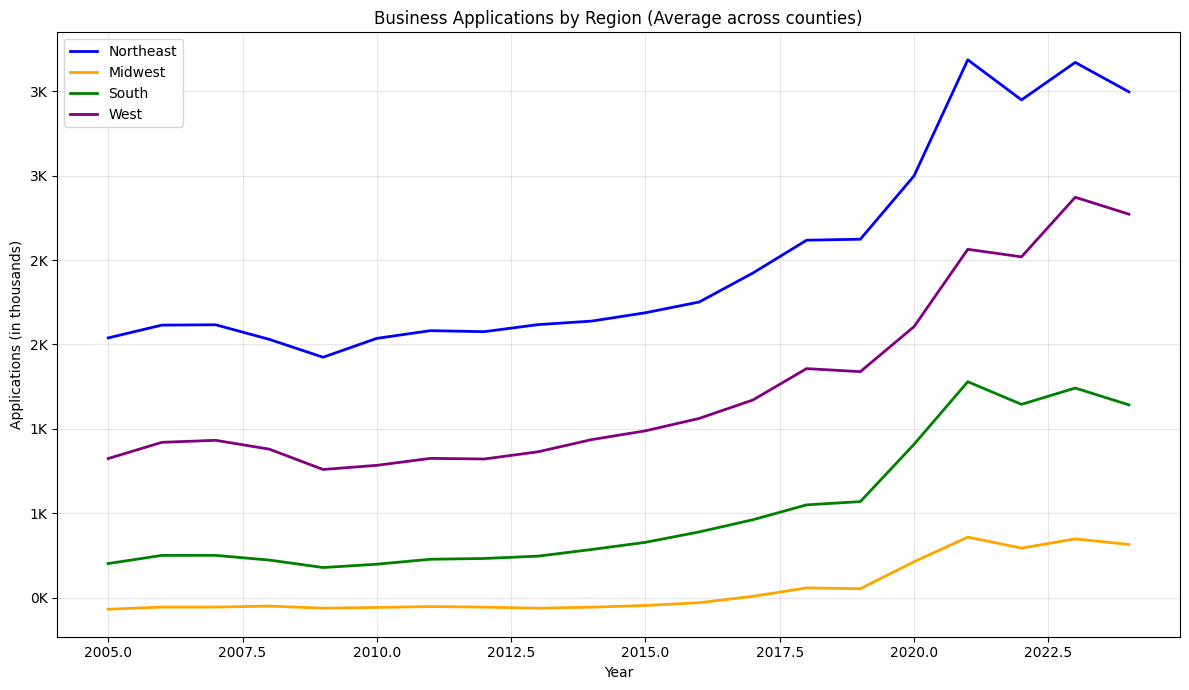

In [237]:
region_trends_mean = get_region_means(df1, regions, year_cols)

plt.figure(figsize=(12, 7))
for r in region_trends_mean.columns:
    plt.plot(region_trends_mean.index, region_trends_mean[r].values,
             label=r, color=REGION_COLORS[r], linewidth=2)
plt.title("Business Applications by Region (Average across counties)")
plt.xlabel("Year")
plt.ylabel("Applications (in thousands)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


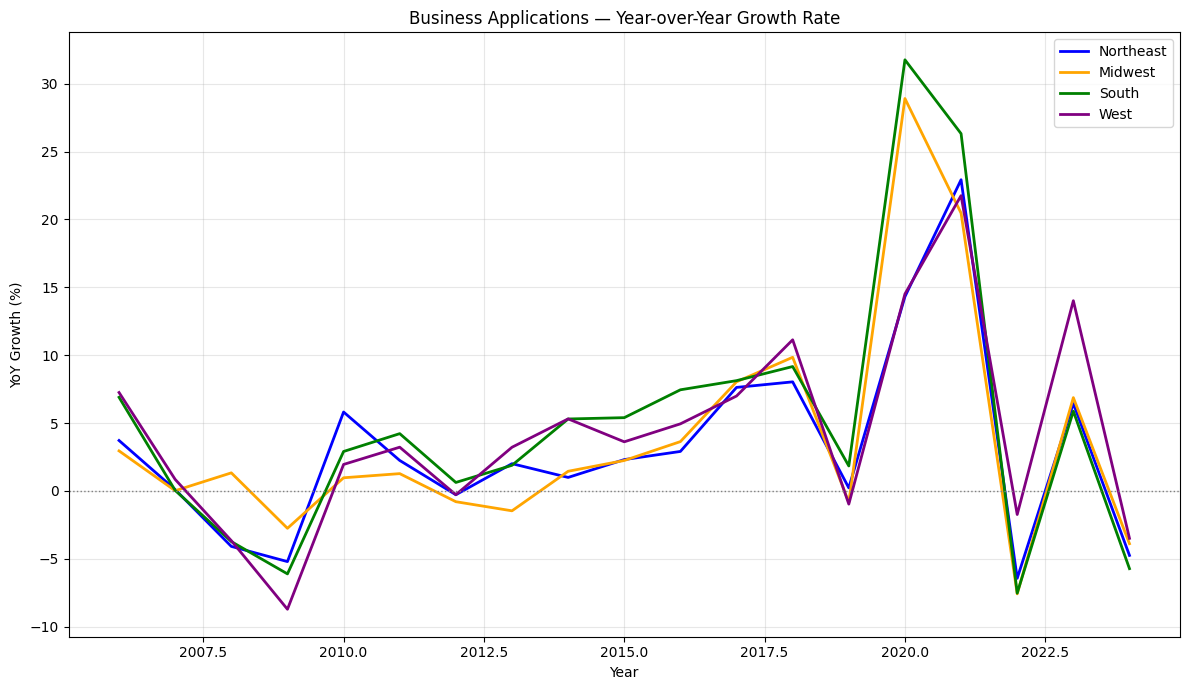

In [238]:
#yoy change %
region_growth_yoy = region_trends_mean.pct_change().dropna()

plt.figure(figsize=(12, 7))
for r in region_growth_yoy.columns:
    plt.plot(region_growth_yoy.index, 100*region_growth_yoy[r].values,
             label=r, color=REGION_COLORS[r], linewidth=2)
plt.axhline(0, color="gray", linestyle=":", linewidth=1)
plt.title("Business Applications — Year-over-Year Growth Rate")
plt.xlabel("Year")
plt.ylabel("YoY Growth (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


This line chart shows the year-over-year growth rate of business applications across US regions from 2005 to 2024. All regions experienced steady but moderate growth through most of the 2010s, followed by a sharp surge around 2020–2021, when new business formations spiked during the pandemic-driven entrepreneurial boom.

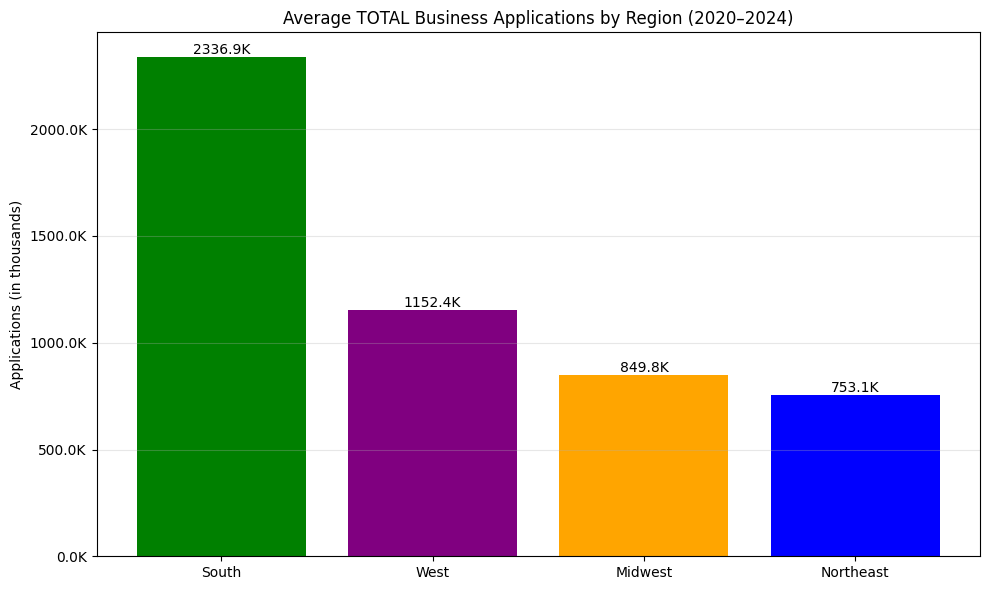

In [239]:
region_trends_total = get_region_totals(df1, regions, year_cols)

recent_years = [y for y in range(2020, 2025) if str(y) in year_cols]
recent_avg_totals = region_trends_total.loc[recent_years].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(recent_avg_totals.index, recent_avg_totals.values,
               color=[REGION_COLORS[r] for r in recent_avg_totals.index])

# labels
for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y, f"{y/1000:.1f}K",
             ha="center", va="bottom", fontsize=10)

plt.title(f"Average TOTAL Business Applications by Region (2020–2024)")
plt.ylabel("Applications (in thousands)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1000:.1f}K"))
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


This boxplot shows the distribution of average county-level business applications from 2020 to 2024 across U.S. regions.

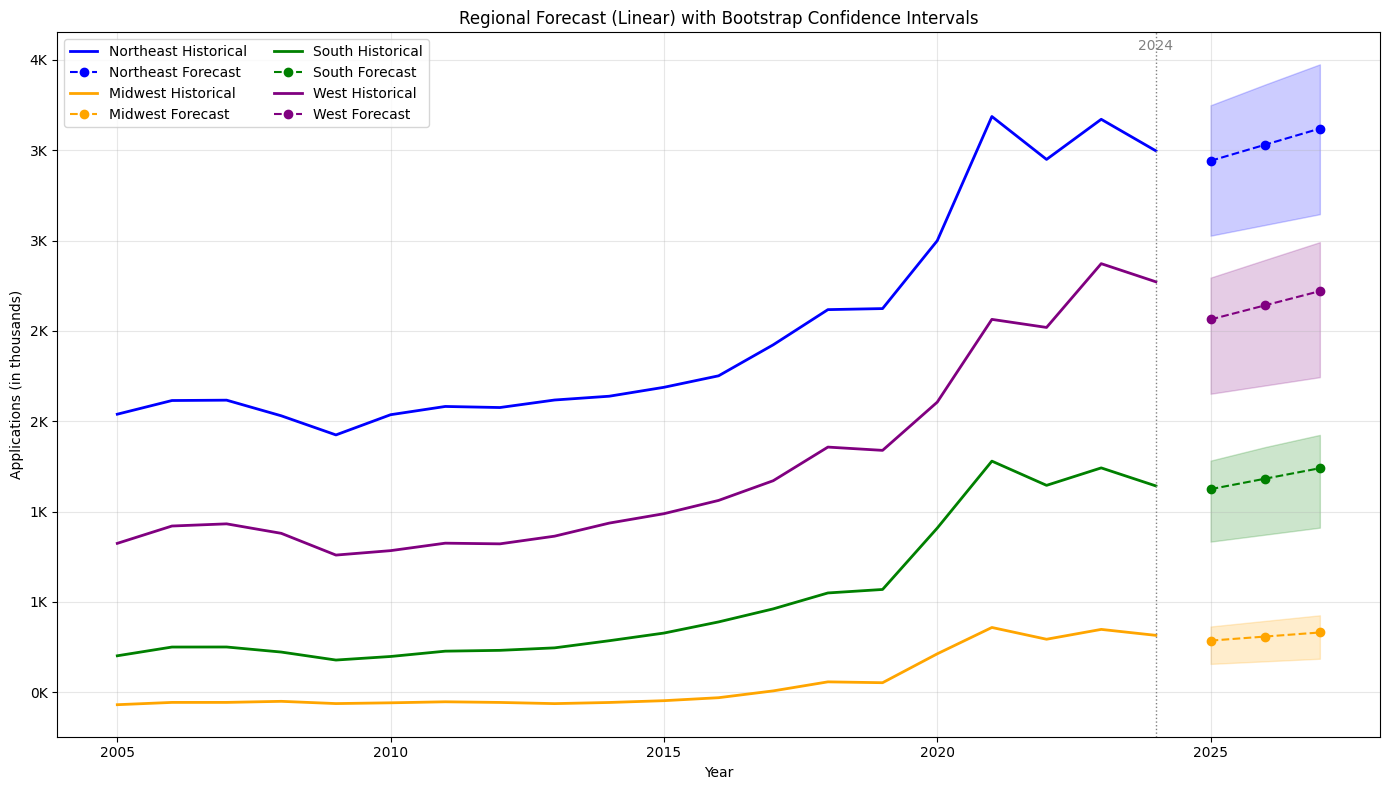

In [240]:
future_years = [y for y in [2025, 2026, 2027]]
X_future = np.array(future_years).reshape(-1, 1)

plt.figure(figsize=(14, 8))
max_y = 0

for r in region_trends_mean.columns:
    y_hist = region_trends_mean[r].values
    X_hist = region_trends_mean.index.values.reshape(-1, 1)

    lin = LinearRegression().fit(X_hist, y_hist)
    y_pred = lin.predict(X_future)
    lo, hi = prediction_interval(lin, X_future, X_hist, y_hist)

    # historical
    plt.plot(region_trends_mean.index, y_hist, color=REGION_COLORS[r], linewidth=2, label=f"{r} Historical")
    # forecast
    plt.plot(future_years, y_pred, color=REGION_COLORS[r], linestyle="--", marker="o", label=f"{r} Forecast")
    # CI
    plt.fill_between(future_years, lo, hi, color=REGION_COLORS[r], alpha=0.2)

    max_y = max(max_y, y_hist.max(), hi.max())

last_hist_year = int(region_trends_mean.index.max())
plt.axvline(x=last_hist_year, color="gray", linestyle=":", linewidth=1)
plt.text(last_hist_year, max_y*1.02, str(last_hist_year), ha="center", color="gray")

plt.title("Regional Forecast (Linear) with Bootstrap Confidence Intervals")
plt.xlabel("Year")
plt.ylabel("Applications (in thousands)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.grid(alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


This fits a simple linear regression model for each region using the historical data to find a line that best represents past trends. Then it uses that line to forecast future values. To make the predictions more reliable, the code adds a confidence interval and refits the model many times on random samples of the data to estimate how much predictions might vary. The final plot shows historical data as solid lines, future predictions as dashed lines, and shaded areas for uncertainty. Theres also a vertical line marking 2024, the last year of historical data, to clearly show where the forecast begins.

<Figure size 1200x700 with 0 Axes>

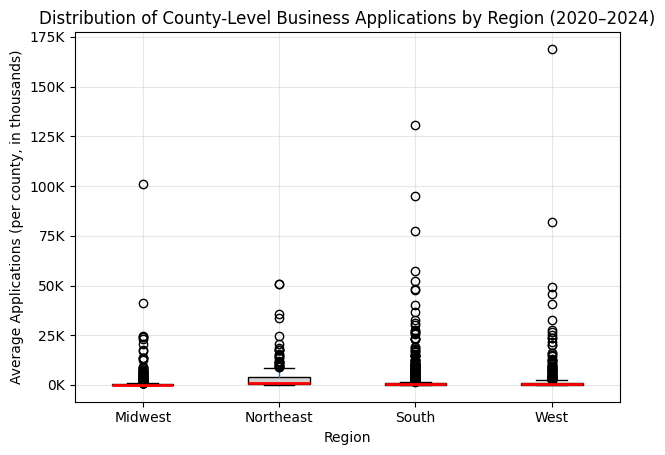

In [241]:
# Visualization — boxplot shows county distribution per region
plt.figure(figsize=(12, 7))
county_avg_recent.boxplot(column="Avg_2020_2024", by="Region", patch_artist=True,
                          boxprops=dict(facecolor="lightgray"),
                          medianprops=dict(color="red", linewidth=2))
plt.title("Distribution of County-Level Business Applications by Region (2020–2024)")
plt.suptitle("")
plt.xlabel("Region")
plt.ylabel("Average Applications (per county, in thousands)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This shows the distribuion by county in the various regions on Business Applications showing outliers. Overall, the graph highlights that while entrepreneurship is spread nationwide

# Results 

In [242]:
degree = 5  
predictions = []
actuals = []

for region, states_list in regions.items():
    region_data = df1[df1['State'].isin(states_list)][year_cols].mean()
    X_all = np.array([int(year) for year in year_cols]).reshape(-1, 1)
    y_all = region_data.values

    #Rolling predictions for last 4 years
    for i in range(len(year_cols) - 4, len(year_cols)):
        X_train = X_all[:i]
        y_train = y_all[:i]
        X_test = X_all[i].reshape(1, -1)
        y_test = y_all[i]

        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]

        predictions.append(y_pred)
        actuals.append(y_test)

    #Compute metrics for region
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    print(f"Region: {region} - Backtest (last 4 yrs) - RMSE: {rmse:.2f}, R^2: {r2:.2f}")



Region: Northeast - Backtest (last 4 yrs) - RMSE: 519.31, R^2: -23.69
Region: Midwest - Backtest (last 4 yrs) - RMSE: 382.64, R^2: 0.92
Region: South - Backtest (last 4 yrs) - RMSE: 369.49, R^2: 0.90
Region: West - Backtest (last 4 yrs) - RMSE: 350.85, R^2: 0.89


The last part evaluates how well a more flexible model might perform. It uses polynomial regression (with 5 degrees) instead of aw straight line, which can better fit curved trends. The code tests this model by pretending it’s forecasting past years.This trains on all data up to a certain year, predicts the next one and compares the prediction to the real value. It repeats this for the last few years and then measures accuracy using RMSE and R^2 

**Question 1: Which U.S. regions have experienced the fastest growth in new business applications over time?**

- West and South have experienced the fastest growth in business applications over the past two decades. The West started with moderately high application levels around 2005 and showed strong and steady increases after 2015, accelerating sharply between 2018 and 2021. Although there was a small dip after 2022, it still remains the region with the highest overall number of business applications.

**Question 2: How do different regions compare in terms of business application volume in recent years?** 

- The South overwhelmingly leads in total business applications, averaging around 2.3 million per year, followed by the West at about 1.15 million, the Midwest at 850,000, and the Northeast at roughly 750,000. This means the South accounts for nearly double the business formation activity of the next-highest region. The West maintains strong totals due to its innovation hubs (California, Washington, Colorado), though high costs and saturation slow its relative growth. 

**Question 3: How well can we predict future business formation activity based on historical data?**

- The confidence intervals are fairly narrow, indicating that the linear regression model is stable and reasonably confident about its predictions. This indicates historical data does a good job of forecasting business formation trends, and the model suggests continued regional growth without major shifts or volatility through 2027.